# Introduction to Natural Language Processing & API Data Access in Python

In this lesson you will learn how to take a set of tweets and clean them in order to 
analyze the frequency of words found in the tweets. You will learn how to do several things 
including:

1. Remove url's from tweets
1. Clean up tweet text including differences in case that will affect unique word counts 
2. Summarize and count individual and sets of words found in tweets

You can use this notebook as the basis for your homework for this week. One option to make things easier is to simply adjust the code in this notebook, and remove the cells that you do not need for your analysis. 


## Get and Analyze Tweets - Natural Language Processing in Python

When you work with social media and other text data the user community creates and
curates the content. This means there are NO RULES! This also means that you may
have to perform extra steps to clean the data to ensure you are analyzing the right
thing.

Next, you will explore the text associated with a set of tweets that you access using tweepy and the twitter API. You will use some standard natural language processing (also known as text mining) approaches to do this.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
from collections import Counter
from textblob import TextBlob

import tweepy as tw
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk import bigrams
import re

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

Remember to define your keys: 

```python 
consumer_key= 'yourkeyhere'
consumer_secret= 'yourkeyhere'
access_token= 'yourkeyhere'
access_token_secret= 'yourkeyhere'
```

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

Once you have authenticated, you can access twitter. If you app is read + write permissions you can even post a tweet.

Give it a try now!

```# Post a tweet from Python
# This is a markdown cell but you can tweet using the code below but coping it into a code cell!
api.update_status("Look, I'm tweeting from #Python in my #earthanalytics class! @EarthLabCU")
```

In [61]:
# Uncomment to tweet
#api.update_status("Look, I'm actually in class tweeting from #Python in my #earthanalytics class! @EarthLabCU")


Now that you've authenticated you're ready to search for tweets that contain `#climatechange`. Below you grab 1,000 recent tweets filtering out retweets. Remember that a retweet is when you share someone elses tweet. 

In [41]:
# list comprehension
numbers = [1,2,3,4]
[num + 1 for num in numbers]

mylist = []
for num in numbers:
    mylist.append(num+1)

[2, 3, 4, 5]

In [39]:
search_term = "#climate+change -filter:retweets"

tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en",
                   since='2018-04-23').items(1000)

all_tweets = [tweet.text for tweet in tweets]
all_tweets[:5]

['With #Climate Change, Where Will Be the Next Energy Capital? https://t.co/F7TpytRMbw\n#WednesdayWisdom read #NAC4… https://t.co/68T7hyf2jK',
 'Five Big Ways the United States Will Need to Adapt to Climate Change https://t.co/1JaEsNuI9U #climate',
 "#Climate change will take a bite out of our economy. Here's what Indianapolis wants to do about it.… https://t.co/cRowA1TxpQ",
 'https://t.co/PWnXgpOyx0 #Nuclear power - the thirstiest source of energy #climate  #auspol NO #thorium https://t.co/yGSSOWBpmt',
 'No surprises that the top #ESG criteria for institutional investors are conflict risks, tobacco, #climatechange,… https://t.co/l7NUgP9C9I']

### Clean Up Twitter Data - Remove URL's (links) From Each Tweet

The tweets above have some elements that you do not want in your word counts. For instance you don't want to include url's in your analysis. You can remove url's using regular expressions accessed from the `re` package. Regular expressions are a special syntax that is used to identify patterns in a text string. While this lesson will not cover regular expressions, below - this syntax:

`([^0-9A-Za-z \t])|(\w+:\/\/\S+)`

tells Python to find all strings that look like a url, and replace it with nothing --  `""`. It also removes other punctionation including hashtags - `#`.

`re.sub` allows you to substitute a selection of characters defined using a regular expression, with something else. 

In the function below, this line takes the text in each tweet and replaces the url with `""` (nothing).

`re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet`


In [5]:
def remove_url(txt):
    """Replace url's found in a 
    text string with nothing (ie it will remove the url from 
    the string.)

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

Then call the function in a list comprehension. A list comprehension is a clever way to implement a `for loop` in python - when you want the output of the `for loop` to be a list. Below you loop through each tweet in the all_tweets object, and you apply the `remove_url()` function to it. This removes urls from each item in your list of tweets and creates a new list with the cleaned tweets. 


In [42]:
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]
all_tweets_no_urls[:5]

['With Climate Change Where Will Be the Next Energy Capital WednesdayWisdom read NAC4',
 'Five Big Ways the United States Will Need to Adapt to Climate Change climate',
 'Climate change will take a bite out of our economy Heres what Indianapolis wants to do about it',
 'Nuclear power the thirstiest source of energy climate auspol NO thorium',
 'No surprises that the top ESG criteria for institutional investors are conflict risks tobacco climatechange']

In [ ]:
# The list comprehension above, does the same thing that this line does
# But with less code and removing the .append() call which can be slower
my_tweets = []
for tweet in all_tweets:
    my_tweets.append(remove_url(tweet))
    
my_tweets[0]

### Text Cleanup - Address Case Issues

Capitalization is also a challenge when analyzing text data. If you are trying to create a list of unique words in your tweets, words with capitalization will be different from words that are all lowercase.

In [43]:
# Note how capitalization impacts unique returned values
ex_list = ["Dog", "dog", "dog", "cat", "cat", ","]
# Get unique elements in the list
set(ex_list)

{',', 'Dog', 'cat', 'dog'}

To account for this you can make each word lowercase using the string method `.lower()`. Below that method is applied using a list comprehension.

In [44]:
# Note how capitalization impacts unique returned values
words_list = ["Dog", "dog", "dog", "cat", "cat", ","]
# Make all elements in the list lowercase

lower_case = [word.lower() for word in words_list]
# Get unique elements in the list
lower_case

['dog', 'dog', 'dog', 'cat', 'cat', ',']

Now all of the words in your list are lower case. Thus the `set()` function will return only unique words.

In [ ]:
# Now you have only unique words
set(lower_case)

### Create List of Words from Tweets

Right now you have a list of lists that contains each full tweet. However to do a word frequency analysis, you need a list of all of the words associated with each tweet. You can use `.split()` to split out each word into a unique element in a list. 


In [ ]:
# Split the words from one tweet into unique elements
all_tweets_no_urls[0].split()

Of course you will notice above that you have a capital word in your list of words. You can combine `.lower()` with `.split()` to remove capital letters and split up the tweet in one step. 

In [45]:
# Split the words from one tweet into unique elements
all_tweets_no_urls[0].lower().split()

['with',
 'climate',
 'change',
 'where',
 'will',
 'be',
 'the',
 'next',
 'energy',
 'capital',
 'wednesdaywisdom',
 'read',
 'nac4']

To split words in all of the tweets, you can then string both methods together in a list comprehension.


In [46]:
# Create a sublist of words for each tweet, all lower case
words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]
words_in_tweet[0:2]

[['with',
  'climate',
  'change',
  'where',
  'will',
  'be',
  'the',
  'next',
  'energy',
  'capital',
  'wednesdaywisdom',
  'read',
  'nac4'],
 ['five',
  'big',
  'ways',
  'the',
  'united',
  'states',
  'will',
  'need',
  'to',
  'adapt',
  'to',
  'climate',
  'change',
  'climate']]

## Remove Stopwords From Tweet Text With `nltk`

The `python` package `nltk` is commonly used for text analysis. Included in this package is a list of "stop words", these include commonly appearing words such as  who, what, you, ect. that generally don't add meaningful information to the text you are trying to analysis. 

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/leah-
[nltk_data]     su/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
stop_words = set(stopwords.words('english'))
# View a few words from the set
list(stop_words)[0:10]

['nor', 'have', 'to', "that'll", 'm', 'that', 'y', "couldn't", 'wasn', 'under']

Notice that the stop words provided by `nltk` are all lower-case. This works well given you already have converted all of your tweet words to lower case using the `python` `string` method `.lower()`. Next you will remove all stop words from each tweet. First, have a look at the words in the first tweet below.

In [11]:
# Notice how many stop words are in these tweets
# This will impact your frequency analysis
words_in_tweet[0]

['with',
 'the',
 'national',
 'talk',
 'on',
 'environment',
 'amp',
 'climate',
 'we',
 'feel',
 'starting',
 'in',
 'your',
 'own',
 'backyard',
 'and',
 'leading',
 'my',
 'example',
 'is']

Below, you remove all of the stop words in each tweet. The list comprehension below might look confusing as it's nested. The list comprehension below is the same as calling:

```python
for all_words in words_in_tweet:
    for a word in all_words:
        # remove stop words
```

Compare the words in that tweet, to the words in the tweet once the stop words are removed: 

In [48]:
# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]
tweets_nsw[0]

['climate',
 'change',
 'next',
 'energy',
 'capital',
 'wednesdaywisdom',
 'read',
 'nac4']

### Remove Collection Words

In additional to removing stopwords it's common to also remove collection words. Collection words are the words that you used to query your data from twitter. This case you used `climate change` as a collection term. Thus you can expect that these terms will be found in each tweet. This could skew your word frequency analysis. 

Remove the words - climate, change, and climatechange - from the tweets. 

In [13]:
collection_words = ['climatechange', 'climate', 'change']

In [51]:
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]
tweets_nsw_nc[0]

['next', 'energy', 'capital', 'wednesdaywisdom', 'read', 'nac4']

### Calculate Word Frequency

Now that you have cleaned up your data, you are ready to calculate word frequencies. To begin, flatten your list. Note that you could flatten your list with another list comprehension like this:

`all_words = [item for sublist in tweets_nsw for item in sublist]`

But it's actually faster to use itertools to flatten the list as follows

In [53]:
# Flatten the tweets_nsw
all_words_nsw = list(itertools.chain(*tweets_nsw))
len(all_words_nsw)

10561

In [56]:
# Create word list without collection collection 
all_words_nsw_nc = list(itertools.chain(*tweets_nsw_nc))
len(all_words_nsw_nc)


8926

Now you have a list of words from your tweets. Remember that from this sample the average tweet length was about 16 words, before the stop words are removed, so this number seems reasonable. 

To get the count of how many times each words appears in the sample you can use the built-in `Python` library `collections`, it helps create a special type of a `Python dictonary.`

In [62]:
# Create counts for list of words with stop words and collection words removed
all_words_nsw_nc_counts = collections.Counter(all_words_nsw_nc)
type(counts_with_collection_words)

collections.Counter

Lookat the counts for your data including the collection words. Notice that the words climate, change and climatechange are prevalent in your analysis given they were a collection term. Thus, it likely does make sense to remove them from this analysis.

The `collection.Counter` object has a useful built-in method `most_common` that will return the most commonly used words, and the number of times that they are used. 

In [60]:
# View word counts for list that includes collection terms
all_words_nsw_nc_counts.most_common(15)

[('report', 136),
 ('trump', 120),
 ('us', 74),
 ('believe', 65),
 ('new', 57),
 ('amp', 52),
 ('globalwarming', 46),
 ('science', 43),
 ('says', 42),
 ('world', 41),
 ('via', 41),
 ('gpwx', 38),
 ('government', 37),
 ('dont', 37),
 ('could', 35)]

In [25]:
# View word counts for list that does NOT INCLUDE collection terms
all_words_nsw_nc_counts = collections.Counter(all_words_nsw_nc)
cleaned_tweet_word_list.most_common(15)

[('report', 136),
 ('trump', 120),
 ('us', 76),
 ('believe', 65),
 ('new', 58),
 ('amp', 54),
 ('globalwarming', 44),
 ('says', 41),
 ('via', 41),
 ('world', 40),
 ('science', 40),
 ('government', 38),
 ('gpwx', 36),
 ('national', 35),
 ('dont', 35)]

Finally, turn your list of words into a pandas dictionary for analysis and plotting.

In [63]:
all_words_counts_df = pd.DataFrame(all_words_nsw_nc_counts.most_common(15),
                             columns=['words', 'count'])
all_words_counts_df.head()

,words,count
0,report,136
1,trump,120
2,us,74
3,believe,65
4,new,57


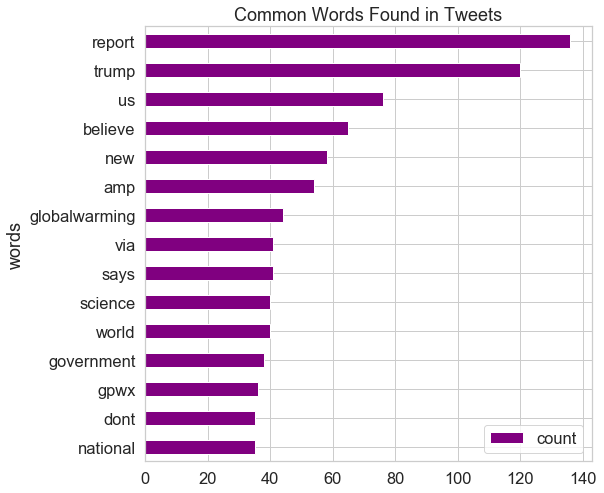

In [35]:
# Note that below I sorted the data while plotting
fig, ax = plt.subplots(figsize=(8, 8))

all_words_counts_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Common Words Found in Tweets")
plt.show()

## Sentiment Analysis

A sentiment analysis is an approach to classifying sets of words. The most basic sentiment analysis will classify tweets to see if the message is for example generally positive or negative. This type of analysis might be useful for instance if you are trying to understand:

1. Feelings about the current political environment
2. General sentiment around say a movie or a book review, or even a restaurante

and more. To perform a sentiment analysis it's good to remove urls as you did before just in case there are words that might throw off a sentiment analysis. However you don't need to worry about case or splitting each word into a new item in a list. The analysis will be performed on all words in each tweet.

To begin the sentiment analysis, you can use the list of tweets with url's removed created above. 

In [36]:
# All tweets with URL's removed
all_tweets_no_urls[0:4]

['With the national talk on environment amp climate we feel starting in your own backyard and leading my example is',
 'New report Climate change is a gamble for coastal property owners and everyone else Find out about risks in yo',
 'Californias attorney general clashes with Trumps acting EPA chief over CLIMATE change',
 'Trump Administration Report Recommends Reducing Greenhouse Gas Emissions To Protect Oceans From Climate Change']

The `TextBlob()` function is used to turn individual tweets into a TextBlob object that can be analyzed in many ways. One way is to apply the `sentiment.polarity` on each TextBlob object which returns a sentiment value that ranges from positive (1) to negative (-1). 

In [ ]:

tb_tweets = [TextBlob(tweet) for tweet in all_tweets_no_urls]
tb_tweets[0]

Once you have the textblob object, run `sentiment.polarity` on each tweet. Notice that below you use a list comprehension again to create a list that contains 

1. the tweet sentiment value (ranging between -1 : 1 and
2. the tweet text


In [ ]:
# Classify each tweet by sentiment
tweet_sentiment = [[tweet.sentiment.polarity, str(tweet)] for tweet in tb_tweets]
tweet_sentiment[0]

Now, you are ready to create a pandas dataframe from your list of tweets. 

In [ ]:
tweet_sentiment_df = pd.DataFrame(tweet_sentiment, columns=["polarity", "tweet"])
tweet_sentiment_df.head()

In [ ]:
# Plot your data
fig, ax = plt.subplots()
tweet_sentiment_df.hist(bins=[-1, -.5, -.2, .2, .5, 1],
                        ax=ax,
                        color="purple")
plt.show()